# Romerator - Criador de Imagens Bregas

Há alguns anos, um sujeito resolveu juntar um monte de papel de presente usado com fita isolante e vender como arte. O resultado é muito, muito feito, mas ele está ganhando milhões de dólares fazendo isso. O programa abaixo tenta imitar o assim chamado *estilo*. Uma imagem qualquer é carregada, suas bordas são detectadas e os espaços preenchidos com texturas aleatórias (e feias).

Vamos seguir passo a passo o procedimento. Inicialmente, vamos carregar as bibliotecas necessárias:

* `os`, para lidar com o diretório dos arquivos de texturas;
* `os.path`, para lidar com os caminhos até os arquivos;
* `numpy`, para lidar com as imagens e cálculos genéricos;
* `numpy.random`, para colocar um pouco de aleatoriedade no resultado;
* `PIL` (Pillow), para exibir as imagens;
* `cv2` (OpenCV), para implementação rápida e eficiente de alguns algoritmos.

In [1]:
import os
import os.path as path
import numpy as np
import numpy.random as rnd
from PIL import Image
import cv2

Aqui seguem algumas definições. O arquivo contendo a imagem de entrada está em `input_file`, e o contendo a imagem de saída em `output_file`. As regiões a serem preenchidas com as texturas bregas são definidas aleatoriamente (dentro das bordas da imagem); o parâmetro `N_regions` indica (mais ou menos) quantas regiões diferentes vão surgir na imagem. O parâmetro `structuring_element` é usado para alargar as bordas através de processamento morfológico.

Alguns parâmetros definem como as texturas serão incluídas na imagem. O diretório `texturas` contém imagens que são carregadas, manipuladas e coloridas artificialmente com uma tonalidade aleatória, mais ou menos como nas obras originais. A saturação, em `texture_saturation` é mantida em um valor baixo para preservar os olhos de quem vê o resultado final (o que não é uma preocupação do artista copiado). O valor em `texture_value` pode ser colocado em seu valor máximo para fazer as cores brilharem. 

In [2]:
input_file = 'lena.png'
output_file = 'romerized.png'
N_regions = 100
structuring_element = np.uint8(255 * np.array([
    [ 0, 1, 0 ],
    [ 1, 1, 1 ],
    [ 0, 1, 0 ] ]))
texture_dir = 'texturas'
texture_saturation = 162
texture_value = 255

Vamos agora carregar a imagem. Não há segredos aqui: usamos a função correspondente da biblioteca OpenCV. Para exibir a imagem dentro do notebook, recorremos ao Pillow, mas aqui há algo importante! O OpenCV estrutura imagens coloridas no formato *Blue-Green-Red* (BGR), enquanto o Pillow utiliza o tradicional *Red-Green-Blue*. Portanto, para exibir a imagem, precisamos trocar os canais.

Formato = (512, 512, 3)


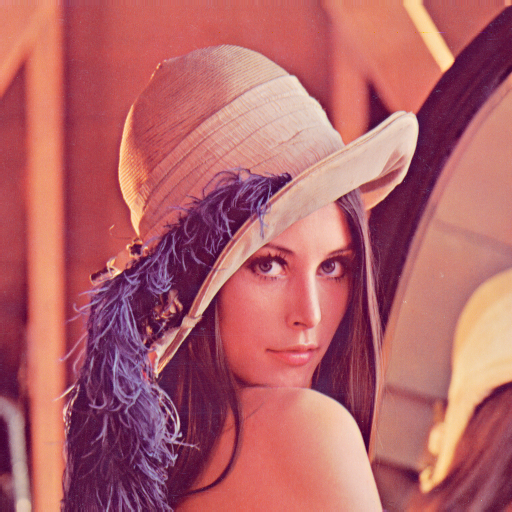

In [3]:
img = cv2.imread(input_file)
rows, cols, _ = img.shape
print(f'Formato = {img.shape}')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
Image.fromarray(img)

Vamos também *quantizar* a imagem: ao invés de lidarmos com 255 níveis de cor, vamos reduzir isso para 4. Isso vai ajudar a determinar mais facilmente as regiões. Você pode obter imagens mais complexas aumentando o número de níveis de quantização, mas isso pode deixar a imagem muito conturbada.

Formato = (512, 512, 3)


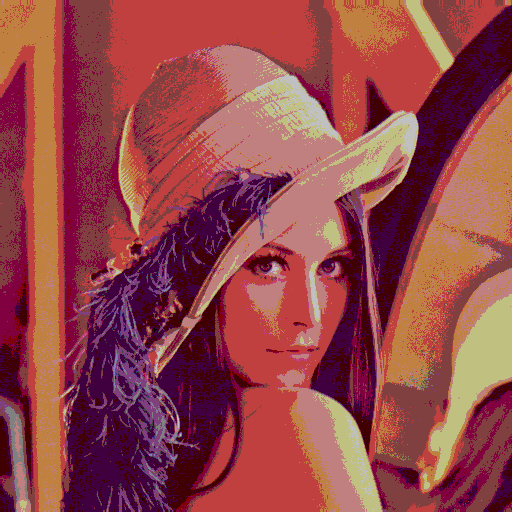

In [4]:
quantized = np.uint8(np.floor(img/64)*64)
print(f'Formato = {quantized.shape}')
Image.fromarray(quantized)

O próximo passo é encontrar as bordas da imagem. Precisamos fazer isso para criar os contornos bem marcados da imagem final. O algoritmo de Canny é uma boa escolha para isso, mas você pode tentar mudar para obter resultados diferentes. Por exemplo, a simples aplicação do operador de Sobel pode te dar resultados diferentes, e talvez até mesmo um contorno melhor conectado. Você provavelmente vai querer ajustar também os parâmetros de *threshold* na chamada ao algoritmo.

Além disso, já que o algoritmo de Canny devolve a borda com apenas um *pixel* de largura, vamos precisar aumentar um pouco sua largura. Isso é facilmente resolvido fazendo a dilatação morfológica, com apenas 1 iteração. Se você quiser uma borda mais larga, aumente esse valor; mas cuidado: um valor muito alto pode acabar transformando a imagem em um grande borrão preto (e é maldade dizer que é melhor que o resultado final).

Formato = (512, 512)


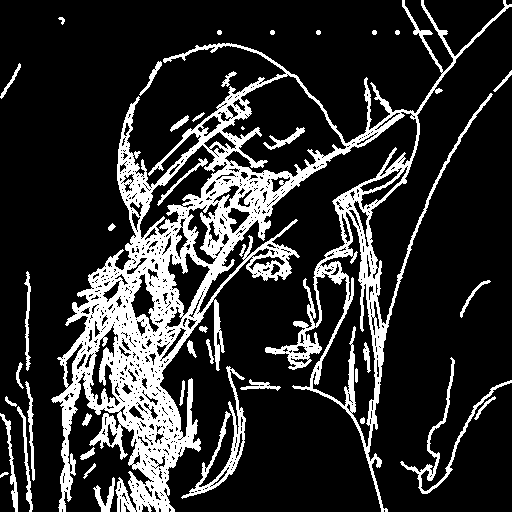

In [5]:
borders = cv2.Canny(img, 100, 200)
borders = cv2.dilate(np.uint8(borders), structuring_element, iterations=1)
print(f'Formato = {borders.shape}')
Image.fromarray(borders)

O próximo passo é encontrar as regiões em que vamos aplicar as texturas. Para isso, apenas vamos sortear alguns marcadores sobre a imagem e deixar as regiões crescerem com um algoritmo de *watershed* simples. Isso gera regiões suficientemente aleatórias - como no estilo do *artista* original.

Uma observação aqui: o OpenCV faz alguma confusão com os tipos enviados às funções, e eu creio que o comportamento esperado para a função `watershed` não é o obtido: é necessário converter a imagem dos marcadores para `cv2.UMat`, e depois converter o resultado de volta. Teste aí, pode ser que a sua versão não precise disso.

Formato = (512, 512)


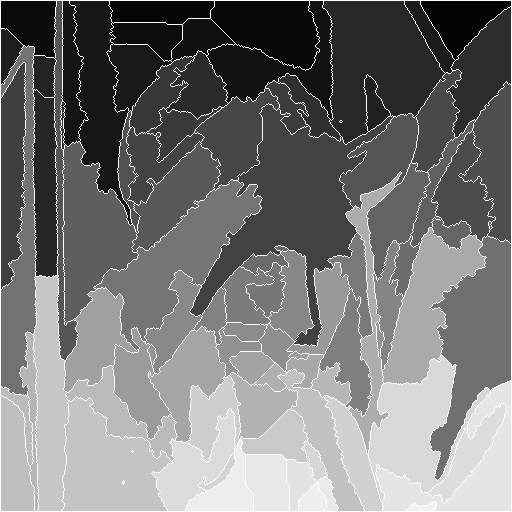

In [6]:
markers = np.where(rnd.random((rows, cols)) < N_regions/(rows*cols), 255, 0)
_, markers = cv2.connectedComponents(np.uint8(markers))
regions = cv2.watershed(quantized, cv2.UMat(markers))
regions = cv2.UMat.get(regions)
print(f'Formato = {regions.shape}')
Image.fromarray(np.uint8(255*regions/N_regions))

Além das bordas da imagem, as regiões aleatórias também têm uma pequena borda que as divide entre si. Vamos realçar esses contornos. Felizmente, não precisamos usar novamente o algoritmo de Canny ou qualquer outro, pois o algoritmo do `watershed` já faz isso para nós. A fronteira das regiões é indefinida, e na imagem retornada, os seus *pixels* têm valor -1. Basta detectar onde eles estão.

Podemos alargar essas fronteiras também, o que pode ser útil se a sua imagem for muito grande. Para isso, remova o comentário da linha que faz a dilatação morfológica e escolha o número de iterações. Faça, no entanto, com que essa borda seja mais fina que as originais.

Formato = (512, 512)


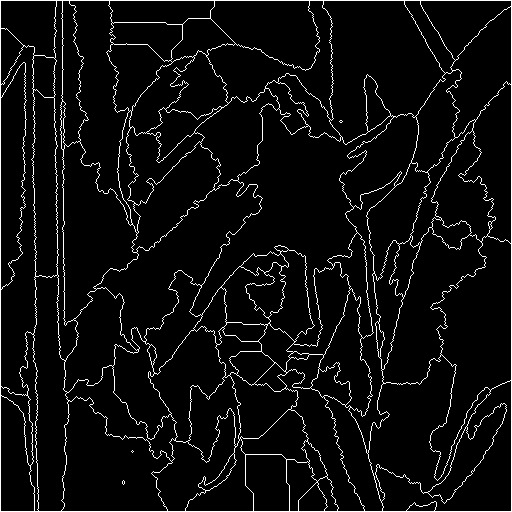

In [7]:
weak_borders = np.uint8(np.where(regions==-1, 255, 0))
#weak_borders = cv2.dilate(weak_borders, structuring_element)
print(f'Formato = {weak_borders.shape}')
Image.fromarray(np.uint8(weak_borders))

Aqui acontece a... magia... Vamos acrescentar as texturas sobre as regiões. As texturas diversas estão na forma de imagens `.png` em um diretório chamado `texturas`, definido anteriormente. O programa percorre esse diretório e gera uma lista com todos os arquivos presentes. Para cada região, escolhe aleatoriamente uma delas, e replica sobre toda a região. Com uma certa probabilidade, ele decide não impor uma textura, mas usa uma cor sólida.

O programa também escolhe uma *bela* cor para impor à textura. O truque aqui é que a cor é escolhida no formato *HSV* (*Hue-Saturation-Value* - *Tonalidade-Saturação-Valor*). A saturação e o valor são mantidos constantes, mas a tonalidade é escolhida aleatoriamente, mais ou menos como nas obras originais.

Após preencher a imagem, ela é convertida para o RGB.

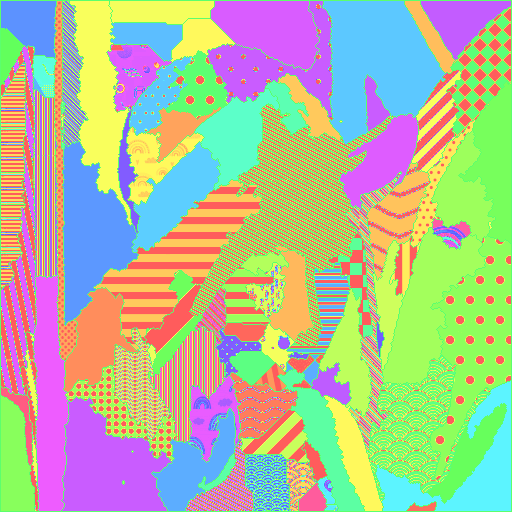

In [8]:
def tile_texture(texture, rows, cols):
    texture_rows, texture_cols = texture.shape
    repeat_rows = int(np.ceil(rows/texture_rows))
    repeat_cols = int(np.ceil(cols/texture_cols))
    tiled = np.tile(texture, (repeat_rows, repeat_cols))
    tiled = tiled[:rows, :cols]
    return tiled

file_list = os.listdir(texture_dir)
texture_image = np.zeros((rows, cols, 3), dtype=int)
region_min = np.amin(regions)
region_max = np.amax(regions)

for i in range(region_min, region_max+1):
    
    if rnd.rand() < 0.5:
        texture = 255 * np.ones((rows, cols))
    else:
        file_name = rnd.choice(file_list)
        texture = cv2.imread(path.join(texture_dir, file_name), cv2.IMREAD_GRAYSCALE)
        texture = tile_texture(texture, rows, cols)
    
    value = rnd.rand()
    texture_image[:,:,0] = np.where(regions==i, value*texture, texture_image[:,:,0])
    texture_image[:,:,1] = np.where(regions==i, texture_saturation, texture_image[:,:,1])
    texture_image[:,:,2] = np.where(regions==i, texture_value, texture_image[:,:,2])

texture_image = cv2.cvtColor(np.uint8(texture_image), cv2.COLOR_HSV2RGB)
Image.fromarray(np.uint8(texture_image))

Que resultado maravilhoso, não é? Agora, só precisamos impor as bordas e teremos um resultado perfeito! Fazemos isso abaixo. O programa simplesmente elimina os *pixels* das bordas, criando um contorno preto.

Formato = (512, 512, 3)


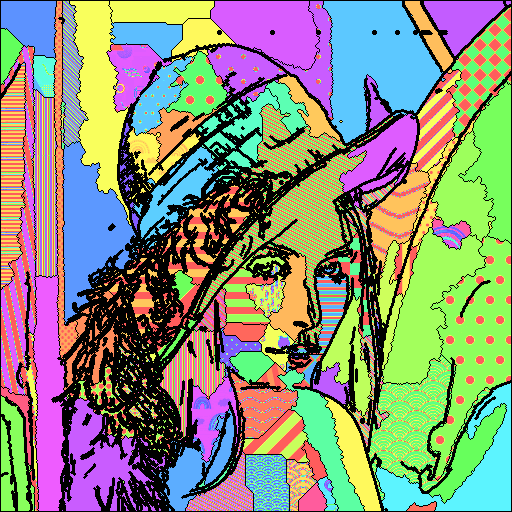

In [9]:
final = np.zeros((rows, cols, 3))
bdr = (255-borders)*(255-weak_borders)
final[:,:,0] = bdr * texture_image[:,:,0]
final[:,:,1] = bdr * texture_image[:,:,1]
final[:,:,2] = bdr * texture_image[:,:,2]
print(f'Formato = {final.shape}')
final = np.select([ final < 0, final <= 255 ], [ 0, final ], 255)
Image.fromarray(np.uint8(final))

Só nos resta agora salvar o resultado.

In [10]:
final = Image.fromarray(np.uint8(final))
final.save(output_file)

Melhor que o original, não é? Espero que tenham gostado!